In [21]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import _pickle as pickle

from pprint import pprint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm
import seaborn as sns
plt.style.use("./files/paper.mplstyle")

from model import *
from utils import *

np.random.seed(12345)

## Dynamics

In [3]:
state = {"n_f" : 492, "n_p" : 4, "n_m" : 4, "p_f" : 10, "p" : 10,}

params = {"sigma_eps" : 0.005, "sigma_mu" : 0.05, "t_c": 0.001, "gamma" : 0.01, 
          "beta": 4, "R": 0.0004, "s": 0.75, "alpha_1": 0.6, "alpha_2": 1.5, 
          "alpha_3": 1, "v_1": 2, "v_2": 0.6, "dt": 0.002}

In [4]:
M = LuxMarchesiModel(state, params)
print(M)

{'n_f': 492, 'n_p': 4, 'n_m': 4, 'p_f': 10, 'p': 10}


In [5]:
totalT = 10000
history = M.simulate(totalT, 1)

100%|██████████| 10000/10000 [01:54<00:00, 87.11it/s]


In [6]:
time = np.arange(0, totalT, 1)

In [7]:
def logReturns(prices, tau, norm=True):
    """
    Compute the log returns of a price time series.
    """
    ln_price = np.log(prices)
    diff = np.diff(ln_price, n=tau)
    if norm: diff = diff/np.std(diff)
    return diff

Text(0.5, 1.0, 'Zoomed in')

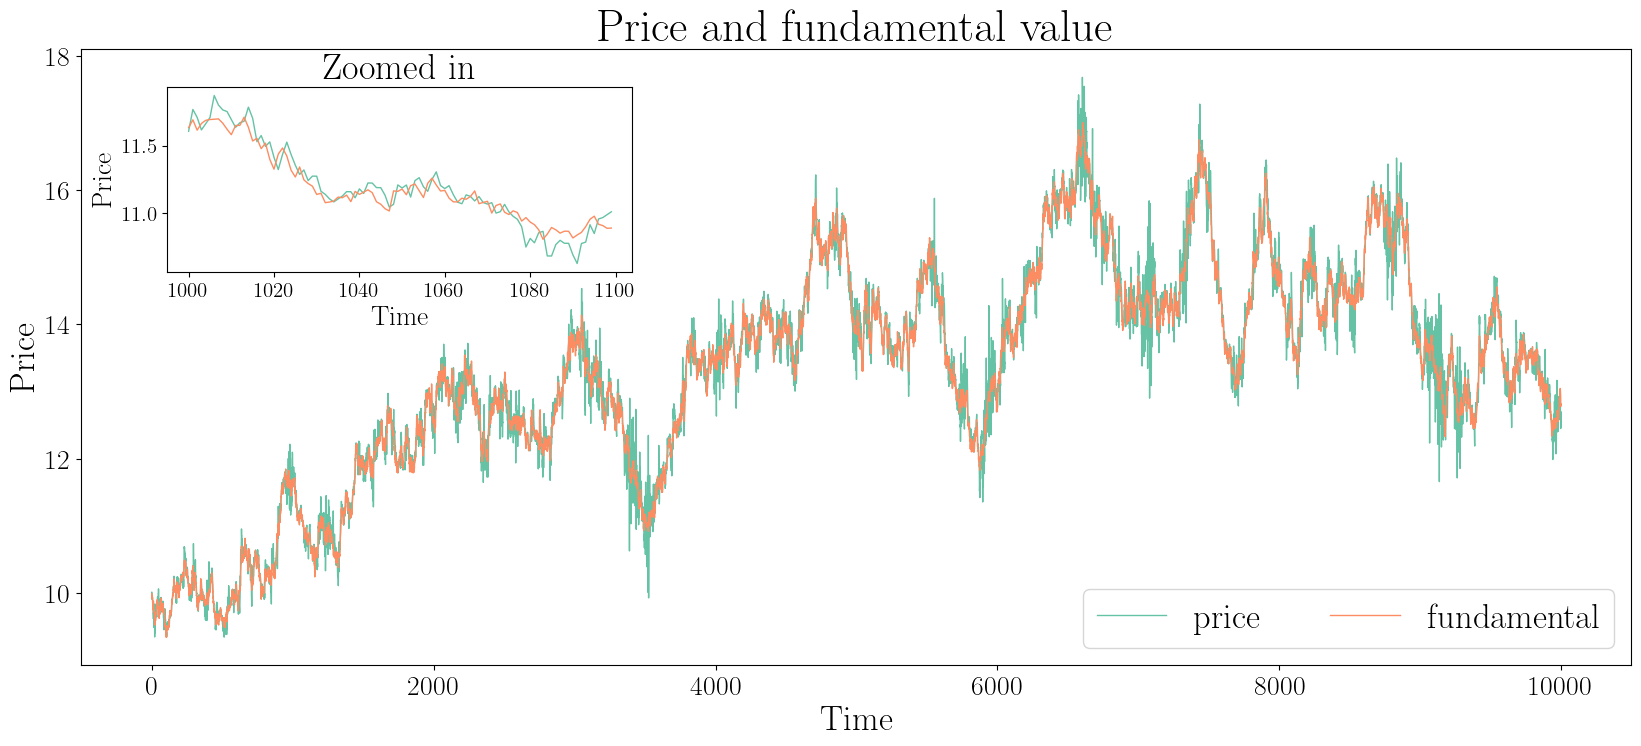

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
colors = sns.color_palette("Set2", 2)
cutoff = (1000, 1100)
fontsize = 25

# Plot the price and the fundamental value
ax.plot(time, history["prices"], lw=1, color=colors[0], label="price")
ax.plot(time, history["fundamentals"], lw=1, color=colors[1], label="fundamental")
ax.set_xlabel("Time", fontsize=fontsize)
ax.set_ylabel("Price", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax.tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
ax.set_title("Price and fundamental value", fontsize=fontsize*1.3)
ax.legend(loc="lower right", fontsize=fontsize, ncol=2)

# Inset with zoomed in plot
inset_ax = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.06, 0.65, 0.3, 0.3), bbox_transform=ax.transAxes)
inset_ax.plot(time[cutoff[0]:cutoff[1]], history["prices"][cutoff[0]:cutoff[1]], lw=1, color=colors[0], label="price")
inset_ax.plot(time[cutoff[0]:cutoff[1]], history["fundamentals"][cutoff[0]:cutoff[1]], lw=1, color=colors[1], label="fundamental")
inset_ax.set_xlabel("Time", fontsize=fontsize*0.8)
inset_ax.set_ylabel("Price", fontsize=fontsize*0.8)
inset_ax.tick_params(axis='both', which='major', labelsize=fontsize*0.6)
inset_ax.tick_params(axis='both', which='minor', labelsize=fontsize*0.6)
inset_ax.set_title("Zoomed in", fontsize=fontsize*1.3*0.8)

ValueError: x and y must have same first dimension, but have shapes (9999,) and (1999999,)

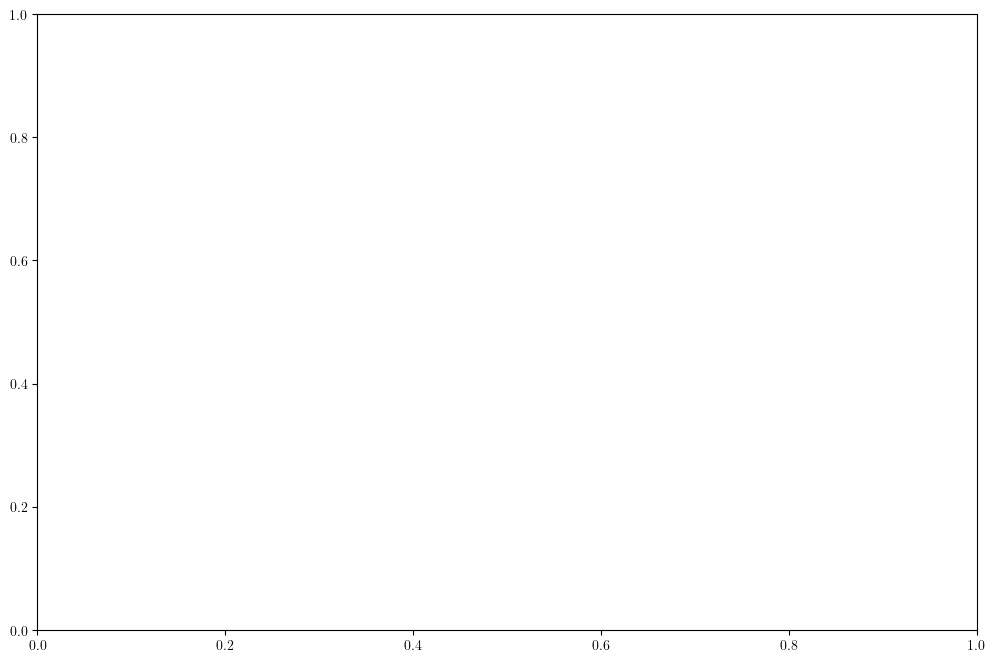

In [18]:
fig = plt.figure(figsize=(20, 8))
colors = sns.color_palette("Set2", 2)
fontsize = 25

ret = np.diff(np.log(history["prices"]))
eps = np.diff(np.log(history["fundamentals"]))

# Define the gridspec to allocate more space to the first plot
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1.5])

# First subplot (series)
ax1 = plt.subplot(gs[0])
ax1.plot(time[1:], ret, lw=1, color=colors[0], label="price")
ax1.plot(time[1:], eps, lw=1, color=colors[1], label="fundamental")
ax1.set_xlabel("Time", fontsize=fontsize)
ax1.set_ylabel("Log returns", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
ax1.set_title("Log returns", fontsize=fontsize*1.3)
ax1.legend(loc="lower right", fontsize=fontsize, ncol=2)

# Second subplot (distributions)
ax2 = plt.subplot(gs[1])
sns.kdeplot(y=ret, color=colors[0], ax=ax2, label="price", fill=True)
sns.kdeplot(y=eps, color=colors[1], ax=ax2, label="fundamental", fill=True)
sns.kdeplot(y=np.random.normal(0, params["sigma_eps"], int(1e6)), color="grey", ax=ax2, label="normal", linestyle="--")
ax2.set_xlabel("Density", fontsize=fontsize)
ax2.set_ylabel("Log returns", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
ax2.set_title("Distributions", fontsize=fontsize*1.3)

plt.show()


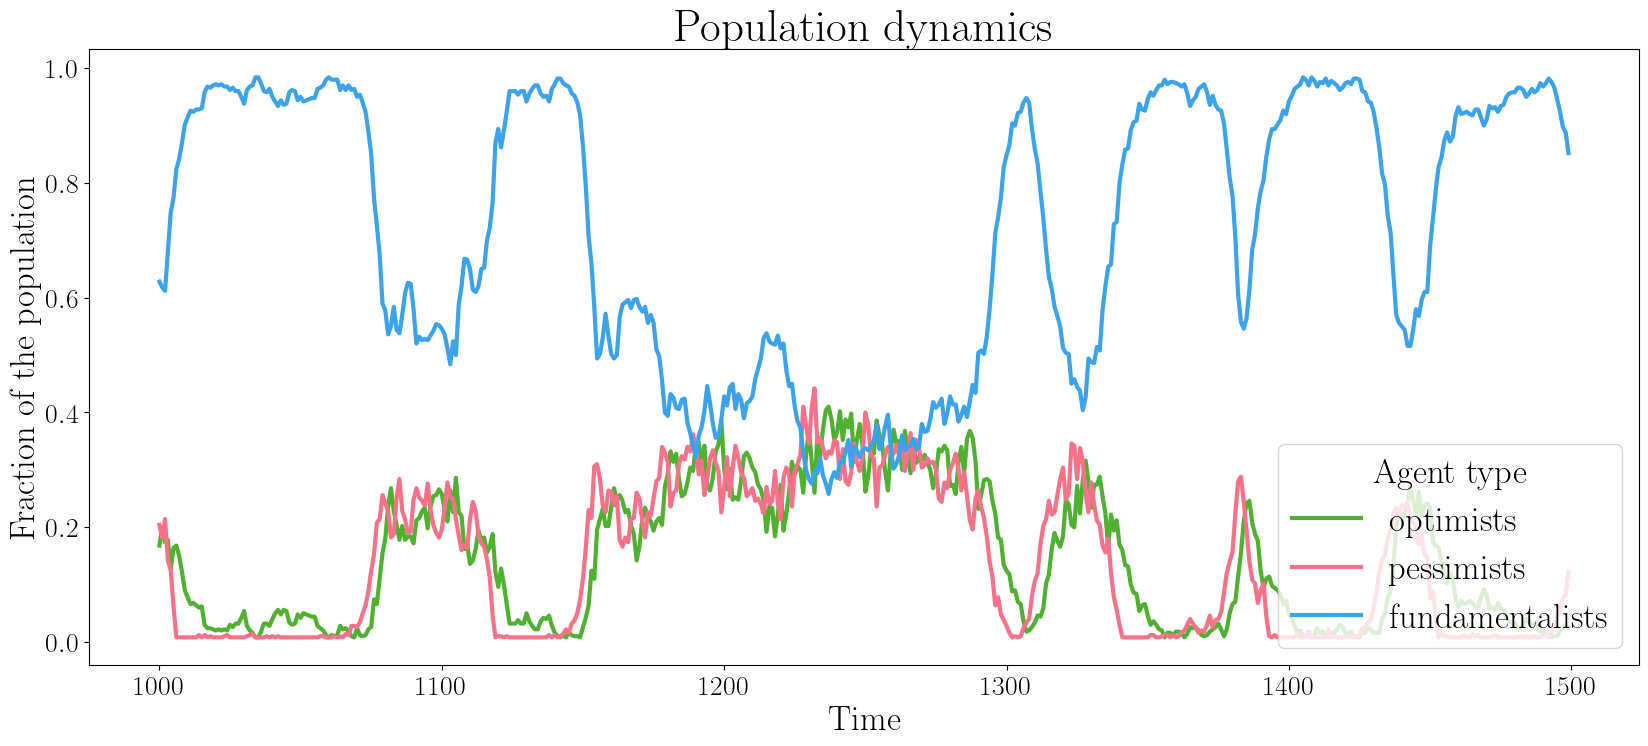

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
fontsize = 25
N = state["n_p"] + state["n_m"] + state["n_f"]
cutoff = (1000, 1500)
colors_pop = sns.color_palette("husl", 3)

ax.plot(time[cutoff[0]:cutoff[1]], history["optimists"][cutoff[0]:cutoff[1]]/N, lw=3, color=colors_pop[1], label="optimists")
ax.plot(time[cutoff[0]:cutoff[1]], history["pessimists"][cutoff[0]:cutoff[1]]/N, lw=3, color=colors_pop[0], label="pessimists")
ax.plot(time[cutoff[0]:cutoff[1]], history["fundamentalists"][cutoff[0]:cutoff[1]]/N, lw=3, color=colors_pop[2], label="fundamentalists")

ax.set_xlabel("Time", fontsize=fontsize)
ax.set_ylabel("Fraction of the population", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax.tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
ax.set_title("Population dynamics", fontsize=fontsize*1.3)
legend = ax.legend(loc="lower right", fontsize=fontsize, ncol=1)
legend.set_title("Agent type", prop={"size": fontsize})
legend.set_alpha(1)

## Long dynamics

In [31]:
# Load the data
with open("files/simul.pkl", "rb") as f:
    history = pickle.load(f)

In [32]:
def empiricalCDF(data):
    """
    Compute the empirical CDF of a dataset.
    """
    x = np.sort(data)
    y = np.arange(1, len(x)+1)/len(x)
    return x, y

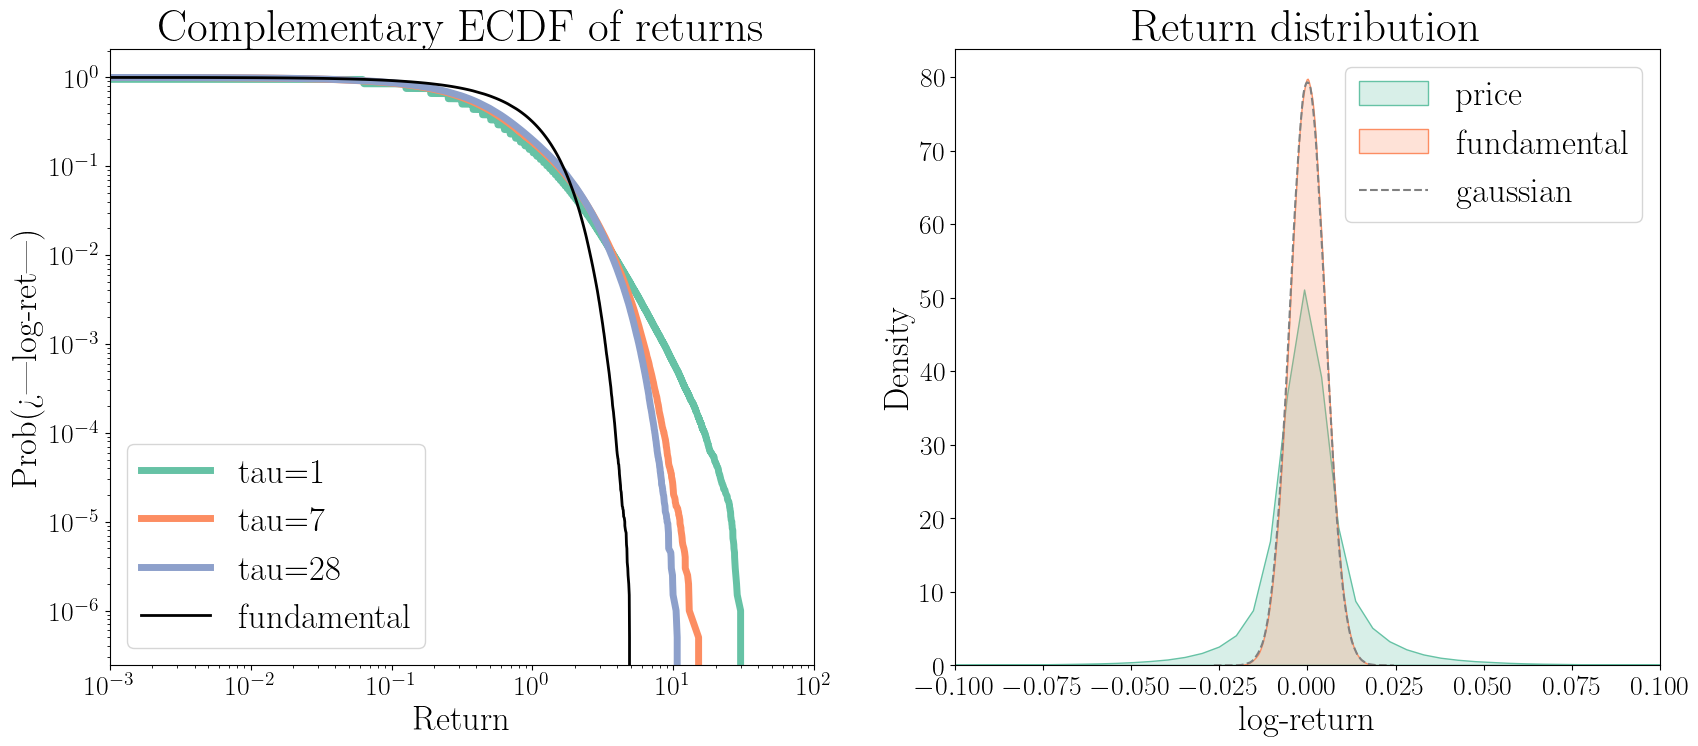

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fontsize = 25
prices = history["prices"]
fundamentals = history["fundamentals"]

ax[0].set_title("Complementary ECDF of returns", fontsize=fontsize*1.3)
tau_list = [1, 7, 28]
markers = ["o", "s", "D", "^", "v"]
colors = sns.color_palette("Set2", len(tau_list))
for tau, marker, color in zip(tau_list, markers, colors):
    # Compute the return for the given tau
    ret = np.abs(logReturns(prices, tau))
    
    # Compute the ECDF and plot the complement
    x, y = empiricalCDF(ret)
    ax[0].loglog(x, 1-y, label=f"tau={tau}", marker="", color=color, 
                 markersize=1, linestyle="-", linewidth=5)

x, y = empiricalCDF(np.abs(logReturns(fundamentals, 1)))
ax[0].loglog(x, 1-y, label="fundamental", marker="", color="black", 
             markersize=1, linestyle="-", linewidth=2)
ax[0].legend(loc="lower left", fontsize=fontsize)
ax[0].set_xlabel("Return", fontsize=fontsize)
ax[0].set_ylabel("Prob(>|log-ret|)", fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax[0].tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
ax[0].set_xlim(1e-3, 100)

ax[1].set_title("Return distribution", fontsize=fontsize*1.3)
ret = np.diff(np.log(history["prices"]))
eps = np.diff(np.log(history["fundamentals"]))
colors = sns.color_palette("Set2", 2)
sns.kdeplot(x=ret, color=colors[0], ax=ax[1], label="price", fill=True)
sns.kdeplot(x=eps, color=colors[1], ax=ax[1], label="fundamental", fill=True)
sns.kdeplot(x=np.random.normal(0, params["sigma_eps"], int(1e6)), color="grey", ax=ax[1], label="gaussian", linestyle="--")
ax[1].set_ylabel("Density", fontsize=fontsize)
ax[1].set_xlabel("log-return", fontsize=fontsize)
ax[1].legend(loc="upper right", fontsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax[1].tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
ax[1].set_xlim(-0.1, 0.1);

In [14]:
def movingAverage(data, w):
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    avg = (cumsum[w:] - cumsum[:-w]) / float(w)
    return avg

In [15]:
def getFluctuation(data, k):
    """
    Compute the fluctuation strength of a time series.
    """
    #Split into M segments of length k
    num_segments = len(data) // k
    segments = np.array_split(data[:num_segments * k], num_segments)

    #Local fit for each segment
    def fit_polynomial(segment, order=1):
        x = np.arange(len(segment))
        coeffs = np.polyfit(x, segment, order)
        fitted_values = np.polyval(coeffs, x)
        return fitted_values

    def fit_polynomials_to_segments(segments, order=1):
        fitted_segments = [fit_polynomial(segment, order) for segment in segments]
        return fitted_segments

    # Linear fit of the segments
    fitted_segments = fit_polynomials_to_segments(segments, 1)
    
    # Compute the MSE for each segment
    variances = np.zeros(len(segments))
    for q in range(len(segments)):
        f_squared = (segments[q] - fitted_segments[q])**2
        variances[q] = np.mean(f_squared)

    # Compute the fluctuation strength
    f_strengths = np.sqrt(np.mean(variances))

    return f_strengths


def doDFA(data, max_k=None, num_points=30):
    """
    Perform Detrended Fluctuation Analysis on a time series.
    """
    if max_k is None: max_k = len(data)
    lengths = np.logspace(2, np.log(max_k), base=np.e, num=num_points, dtype=int)

    # Cumulative sum of the data
    cumsum = np.cumsum(data - np.mean(data))
    
    # Compute the fluctuation strength for each length
    fluctuations = np.zeros(len(lengths))
    for i in tqdm(range(len(lengths))):
        k = lengths[i]
        fluctuations[i] = getFluctuation(cumsum, k)

    return lengths, fluctuations
    

In [46]:
ret = np.abs(logReturns(history["prices"], 1, False))
lengths, fluctuations = doDFA(ret, 5e5, 30)
eps = np.abs(logReturns(history["fundamentals"], 1, False))
lengths_f, fluctuations_f = doDFA(eps, 5e5, 30)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:50<00:00,  1.67s/it]


In [62]:
ret_abs = np.abs(logReturns(history["prices"], 1, False))
lengths_abs, fluctuations_abs = doDFA(ret_abs, 5e5, 30)
eps_abs = np.abs(logReturns(history["fundamentals"], 1, False))
lengths_f_abs, fluctuations_f_abs = doDFA(eps_abs, 5e5, 30)


100%|██████████| 30/30 [00:48<00:00,  1.62s/it]


In [57]:
# Compute the DFA for the absolute returns
ret_abs = np.abs(logReturns(history["prices"], 1, False))
lengths_abs, fluctuations_abs = doDFA(ret_abs, 5e5, 30)
eps_abs = np.abs(logReturns(history["fundamentals"], 1, False))
lengths_f_abs, fluctuations_f_abs = doDFA(eps_abs, 5e5, 30)

# Compute the DFA for the returns
ret = logReturns(history["prices"], 1, False)
lengths, fluctuations = doDFA(ret, 5e5, 30)
eps = logReturns(history["fundamentals"], 1, False)
lengths_f, fluctuations_f = doDFA(eps, 5e5, 30)


100%|██████████| 30/30 [00:48<00:00,  1.62s/it]


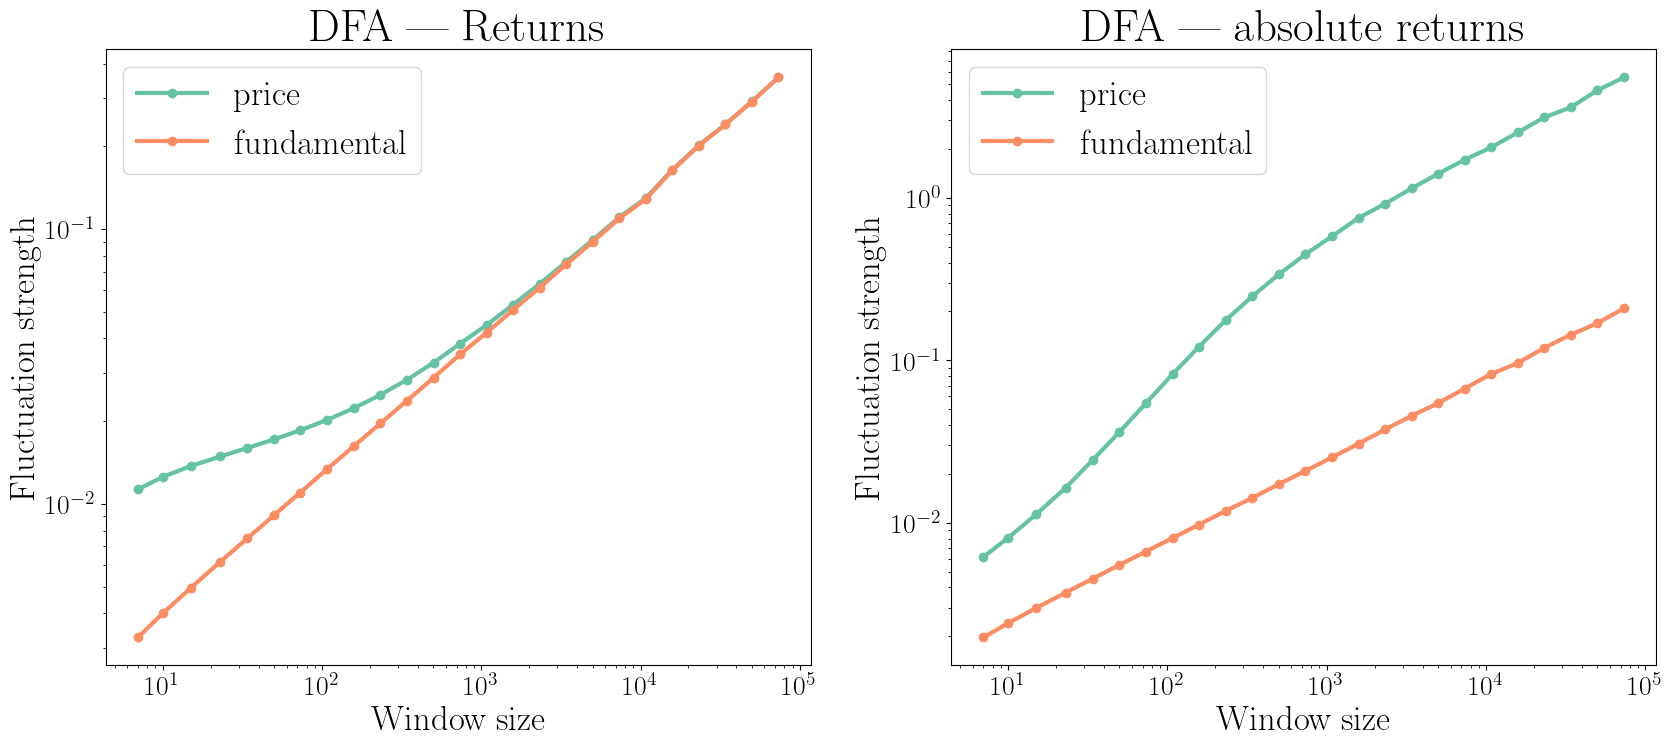

In [63]:
# Plot the DFA results
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fontsize = 25

# Compute the DFA for the absolute returns
ret_abs = np.abs(logReturns(history["prices"], 1, False))
lengths_abs, fluctuations_abs = doDFA(ret_abs, 5e5, 30)
eps_abs = np.abs(logReturns(history["fundamentals"], 1, False))
lengths_f_abs, fluctuations_f_abs = doDFA(eps_abs, 5e5, 30)

# Compute the DFA for the returns
ret = logReturns(history["prices"], 1, False)
lengths, fluctuations = doDFA(ret, 5e5, 30)
eps = logReturns(history["fundamentals"], 1, False)
lengths_f, fluctuations_f = doDFA(eps, 5e5, 30)

# Define the data cutoff
cutoff = (0, 1e5)
mask = (lengths > cutoff[0]) & (lengths < cutoff[1])

# Plot 
ax[0].plot(lengths[mask], fluctuations[mask], "o-", lw=3, color=colors[0], label="price")
ax[0].plot(lengths_f[mask], fluctuations_f[mask], "o-", lw=3, color=colors[1], label="fundamental")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel("Window size", fontsize=fontsize)
ax[0].set_ylabel("Fluctuation strength", fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax[0].tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
ax[0].set_title("DFA | Returns", fontsize=fontsize*1.3)
ax[0].legend(loc="upper left", fontsize=fontsize)

ax[1].plot(lengths_abs[mask], fluctuations_abs[mask], "o-", lw=3, color=colors[0], label="price")
ax[1].plot(lengths_f_abs[mask], fluctuations_f_abs[mask], "o-", lw=3, color=colors[1], label="fundamental")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("Window size", fontsize=fontsize)
ax[1].set_ylabel("Fluctuation strength", fontsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize*0.8)
ax[1].tick_params(axis='both', which='minor', labelsize=fontsize*0.8)
ax[1].set_title("DFA | absolute returns", fontsize=fontsize*1.3)
ax[1].legend(loc="upper left", fontsize=fontsize)


/tmp/ipykernel_407955/3398857287.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 5e3)


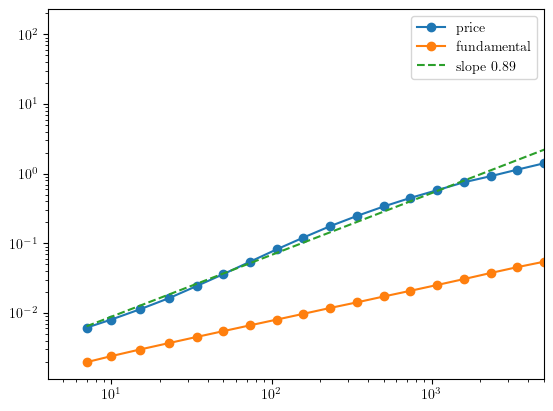

In [52]:

plt.plot(lengths, fluctuations, "o-", label="price")
plt.plot(lengths_f, fluctuations_f, "o-", label="fundamental")

#plt.plot(lengths, 0.1*lengths**0.5, "--", label="slope 0.5")

plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.xlim(0, 5e3)

# Fit a line to the data

mask = (lengths > cutoff[0]) & (lengths < cutoff[1])
coeffs = np.polyfit(np.log(lengths[mask]), np.log(fluctuations[mask]), 1)
plt.plot(lengths, np.exp(coeffs[1]) * lengths**coeffs[0], "--", label=f"slope {coeffs[0]:.2f}")
plt.legend()

In [25]:
n_p = history["optimists"][:500]
n_m = history["pessimists"][:500]
n_f = history["fundamentalists"][:500]

x = (n_p-n_m)/(n_p+n_m)
z = (n_p+n_m)/(n_p+n_m+n_f)

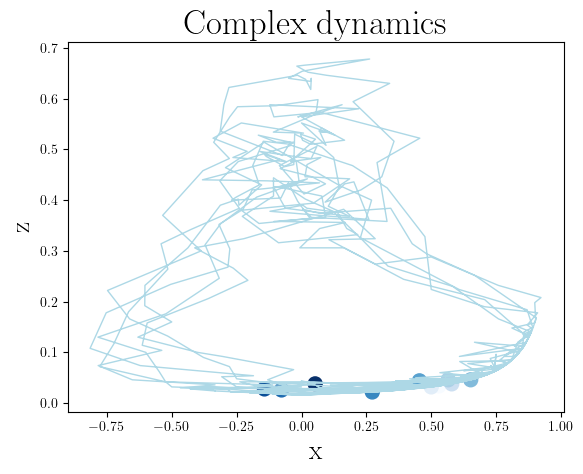

In [30]:
# Parameters for animation
window_size = 10  # Only plot the last 10 points at each step

# Create the figure and axis
fig, ax = plt.subplots()
ax.plot(x, z, lw=1, color='lightblue')  # Plot the line connecting the points
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('z', fontsize=20)
ax.set_title("Complex dynamics", fontsize=25)

# Initialize the scatter plot with an empty set of points
scatter = ax.scatter([], [], s=100)

# Function to initialize the plot (empty frame)
def init():
    scatter.set_offsets(np.empty((0, 2)))  # Initialize with empty 2D array
    scatter.set_facecolor([])              # Initialize with empty color
    return scatter,

# Function to update the plot at each time step
def update(frame):
    # Define the window of points to display
    start_idx = max(0, frame - window_size)
    end_idx = frame

    # Select the last `window_size` points from the current frame
    x_data = x[start_idx:end_idx]
    z_data = z[start_idx:end_idx]

    # Create a 2D array for scatter plot (stack x and z as columns)
    points = np.column_stack([x_data, z_data])

    # Apply a gradient color where the last point is darkest
    color_gradient = np.linspace(1, 0, len(x_data))  # Gradient from light to dark
    colors = cm.Blues_r(color_gradient)  

    # Update the scatter plot with the new data and color gradient
    scatter.set_offsets(points)
    scatter.set_facecolor(colors)  # Apply the gradient colors

    return scatter,

# Create the animation (adjust frames to match the full dataset)
frames = len(x)
ani = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, interval=100)

# Save the animation as a GIF (optional)
ani.save('moving_last_10_points_gradient.gif', writer='pillow', fps=20)